In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from src import config

In [6]:
# 1. Load and Prepare Data
gecko_daily_folder_path = config.GECKO_DAILY_DATA_DIR
gecko_market_cap_path = config.GECKO_MCAP_DATA_DIR
gecko_daily_all_files = [f for f in os.listdir(gecko_daily_folder_path) if f.endswith('.csv')]

gecko_supply_dataset_series = {}
for file in gecko_daily_all_files:
    try:
        data = pd.read_csv(os.path.join(gecko_daily_folder_path, file))
        mc_data = pd.read_csv(os.path.join(gecko_market_cap_path, file))

        # Remove the last row which is often incomplete
        if not data.empty:
            data = data.iloc[:-1]
            
        if not mc_data.empty:
            mc_data = mc_data.iloc[:-1]

        data['Date'] = pd.to_datetime(data['date'])
        data = data.sort_values('Date').drop_duplicates(subset='Date')
        
        mc_data['Date'] = pd.to_datetime(mc_data['date'])
        mc_data = mc_data.sort_values('Date').drop_duplicates(subset='Date')
        
        data_merged = data.merge(mc_data, on='Date')
        data_merged['circulating_supply_proxy'] = data_merged['market_cap'] / data_merged['close']
        
        # Use 'log_Return' column
        supply_series = pd.to_numeric(data_merged['circulating_supply_proxy'])
        supply_series.index = data_merged['Date']

        file_name = file.replace('.csv', '')
        gecko_supply_dataset_series[file_name] = supply_series
        
    except Exception as e:
        print(f"Could not process file {file}: {e}")
        

In [7]:
supply_df = pd.concat(gecko_supply_dataset_series, axis=1)
print(supply_df.head())

            autonomi  rekt-4     goldfinch  tars-protocol  chain-key-bitcoin  \
Date                                                                           
2024-06-28       NaN     NaN  7.611121e+07            NaN         270.735574   
2024-06-29       NaN     NaN  7.604818e+07   1.196149e+08         270.748875   
2024-06-30       NaN     NaN  7.604613e+07   1.192643e+08         270.743627   
2024-07-01       NaN     NaN  7.745170e+07   1.199782e+08         271.689147   
2024-07-02       NaN     NaN  7.796067e+07   1.191751e+08         269.468180   

                   civic  qubic-network        dkargo  kyros-restaked-sol  \
Date                                                                        
2024-06-28  8.018091e+08            NaN  4.191152e+09                 NaN   
2024-06-29  8.011224e+08            0.0  4.185800e+09                 NaN   
2024-06-30  8.013014e+08            0.0  4.181770e+09                 NaN   
2024-07-01  8.010112e+08            0.0  4.319509e+09 

In [8]:
supply_df.to_csv(config.PROCESSED_DATA_DIR / 'circulating_supply_full.csv')

# Calculation method of BGCI Index

--- Calculating BGCI-Style Index ---
All necessary data files loaded successfully.
Data aligned to 363 common dates, from 2024-06-28 to 2025-06-25.

BGCI-style index calculated and saved to: /Users/zacharyvonc/Documents/UCLA/MASDS Thesis/PCA_Index/data/processed/bgci_style_index.csv


/var/folders/17/h1jp6fwn2hgbggdw80lqlsz40000gn/T/ipykernel_63261/1841624946.py:85: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = market_caps.resample('M').last().index


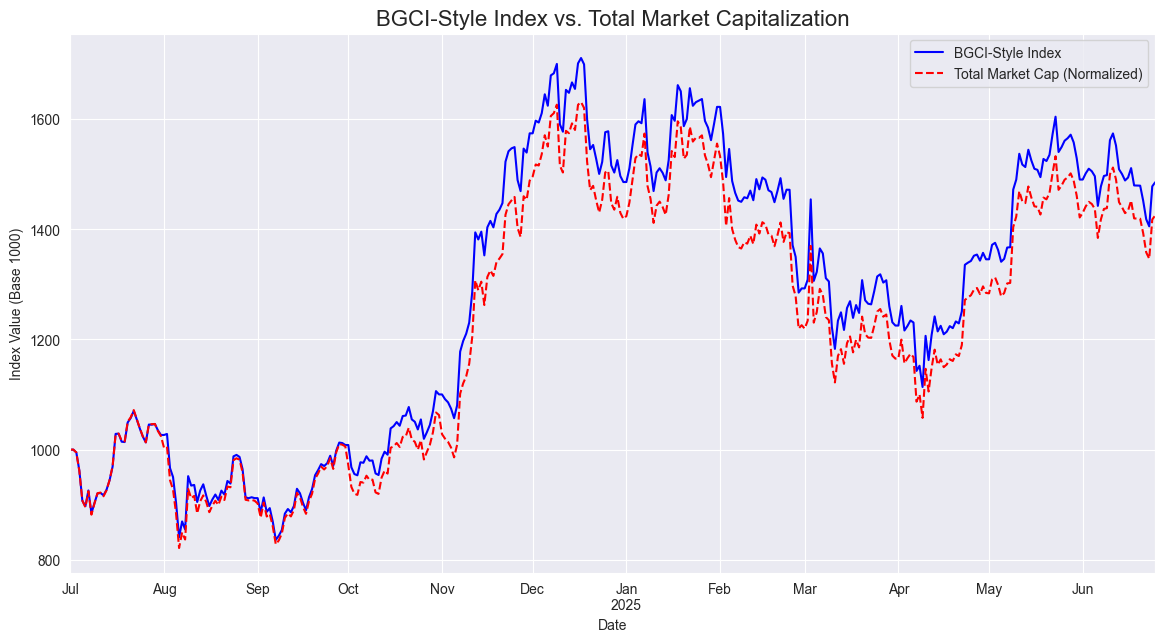

In [3]:
# In scripts/calculate_bgci_index.py

import pandas as pd
import numpy as np
import os
from src import config # Make sure your config file has the necessary paths

def apply_weight_caps(weights, cap=0.35, floor=0.01):
    """
    Iteratively applies a cap and floor to a series of weights,
    redistributing the excess proportionally. This is the core of the BGCI
    weighting scheme.

    Args:
        weights (pd.Series): A series of market-cap weights.
        cap (float): The maximum weight for any single asset.
        floor (float): The minimum weight for any single asset.

    Returns:
        pd.Series: The final, adjusted weights that respect the cap and floor.
    """
    adjusted_weights = weights.copy()
    
    # Iteratively apply cap and floor until no more changes are needed
    for _ in range(10): # Use a loop limit to prevent infinite loops
        # --- Apply the Cap ---
        capped_assets = adjusted_weights > cap
        if capped_assets.any():
            excess_weight = (adjusted_weights[capped_assets] - cap).sum()
            adjusted_weights[capped_assets] = cap
            # Redistribute excess to non-capped assets
            non_capped_assets = ~capped_assets
            redistribution_weights = adjusted_weights[non_capped_assets] / adjusted_weights[non_capped_assets].sum()
            adjusted_weights[non_capped_assets] += excess_weight * redistribution_weights

        # --- Apply the Floor ---
        floored_assets = adjusted_weights < floor
        if floored_assets.any():
            deficit_weight = (floor - adjusted_weights[floored_assets]).sum()
            adjusted_weights[floored_assets] = floor
            # Subtract deficit from non-floored (and non-capped) assets
            eligible_for_subtraction = (adjusted_weights > floor) & (~capped_assets)
            subtraction_weights = adjusted_weights[eligible_for_subtraction] / adjusted_weights[eligible_for_subtraction].sum()
            adjusted_weights[eligible_for_subtraction] -= deficit_weight * subtraction_weights
            
    # Final normalization to ensure weights sum to 1
    return adjusted_weights / adjusted_weights.sum()


def calculate_bgci_index():
    """
    Calculates a BGCI-style index using local market cap, price, and supply data.
    """
    print("--- Calculating BGCI-Style Index ---")

    # --- 1. Load and Align Local Data ---
    try:
        # Load the three separate data files
        market_caps_raw = pd.read_csv(config.MARKET_CAP_FILE_PATH, index_col='Date', parse_dates=True)
        prices_raw = pd.read_csv(config.DAILY_PRICE_FILE_PATH, index_col='Date', parse_dates=True)
        supplies_raw = pd.read_csv(config.DAILY_SUPPLY_FILE_PATH, index_col='Date', parse_dates=True)
        
        print("All necessary data files loaded successfully.")

        # --- Find the intersection of dates available in ALL THREE files ---
        common_dates = market_caps_raw.index.intersection(prices_raw.index).intersection(supplies_raw.index)
        
        if common_dates.empty:
            print("ERROR: No common dates found between the data files. Exiting.")
            return

        # --- Filter all three DataFrames to only the common dates ---
        market_caps = market_caps_raw.loc[common_dates]
        prices = prices_raw.loc[common_dates]
        supplies = supplies_raw.loc[common_dates]

        print(f"Data aligned to {len(common_dates)} common dates, from {common_dates.min().date()} to {common_dates.max().date()}.")

    except FileNotFoundError as e:
        print(f"ERROR: Missing data file. Please ensure all cache files exist. Missing: {e.filename}")
        return

    # --- 2. Monthly Rebalancing and Daily Index Calculation ---
    index_values = []
    rebalance_dates = market_caps.resample('M').last().index
    
    # Initialize the index
    current_index_value = 1000.0
    last_market_value = None

    for i in range(len(rebalance_dates) - 1):
        # --- Rebalancing Day Logic ---
        rebalance_date = rebalance_dates[i]
        
        # Select the top 100 assets based on market cap on the rebalance day
        mcaps_on_rebalance_day = market_caps.loc[rebalance_date].dropna().sort_values(ascending=False)
        top_100_assets = mcaps_on_rebalance_day.head(100).index
        
        # Calculate initial market-cap weights for these 100 assets
        weights_initial = mcaps_on_rebalance_day.loc[top_100_assets] / mcaps_on_rebalance_day.loc[top_100_assets].sum()
        
        # Apply the BGCI capping and flooring rules to get the final weights
        final_weights = apply_weight_caps(weights_initial)
        
        # --- Daily Calculation for the Next Month ---
        start_period = rebalance_dates[i] + pd.Timedelta(days=1)
        end_period = rebalance_dates[i+1]
        
        # Get the data for the holding period for our selected assets
        period_prices = prices.loc[start_period:end_period, top_100_assets]
        period_supplies = supplies.loc[start_period:end_period, top_100_assets]
        
        # Calculate the total market value of the index portfolio for each day
        # Market Value = Sum of (Price * Supply * Weight) for each asset
        # Note: In BGCI, the supply and weight (CF factor) are fixed for the month.
        fixed_supplies = supplies.loc[rebalance_date, top_100_assets]
        
        # Calculate the weighted market value for each day in the period
        daily_market_value = (period_prices * fixed_supplies * final_weights).sum(axis=1)
        
        # Chain-link the index
        if last_market_value is not None:
            # Calculate daily returns of the market value and apply them to the index
            daily_returns = daily_market_value.pct_change().fillna(0)
            period_index_values = current_index_value * (1 + daily_returns).cumprod()
        else:
            # For the very first period, just scale the market value to start at 1000
            period_index_values = 1000 * (daily_market_value / daily_market_value.iloc[0])
            
        index_values.append(period_index_values)
        
        # Update variables for the next loop
        current_index_value = period_index_values.iloc[-1]
        last_market_value = daily_market_value.iloc[-1]

    # --- 3. Finalize and Save the Index ---
    if not index_values:
        print("Could not generate index. Check data ranges.")
        return
        
    final_index = pd.concat(index_values)
    final_index.name = "BGCI_Style_Index"
    
    output_path = config.PROCESSED_DATA_DIR / 'bgci_style_index.csv'
    final_index.to_csv(output_path)
    print(f"\nBGCI-style index calculated and saved to: {output_path}")

    # --- 4. Plot for Visual Comparison ---
    plt.figure(figsize=(14, 7))
    final_index.plot(label='BGCI-Style Index', color='blue')
    
    # Compare with total market cap
    total_market_cap = market_caps.sum(axis=1)
    # Normalize total market cap to start at the same point for comparison
    aligned_market_cap = total_market_cap.reindex(final_index.index)
    normalized_market_cap = 1000 * (aligned_market_cap / aligned_market_cap.iloc[0])
    normalized_market_cap.plot(label='Total Market Cap (Normalized)', color='red', linestyle='--')
    
    plt.title('BGCI-Style Index vs. Total Market Capitalization', fontsize=16)
    plt.ylabel('Index Value (Base 1000)')
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == '__main__':
    calculate_bgci_index()

--- Generating Final Index Comparison Plot ---
All data files loaded successfully.
Data has been normalized to a base of 1000 for comparison.


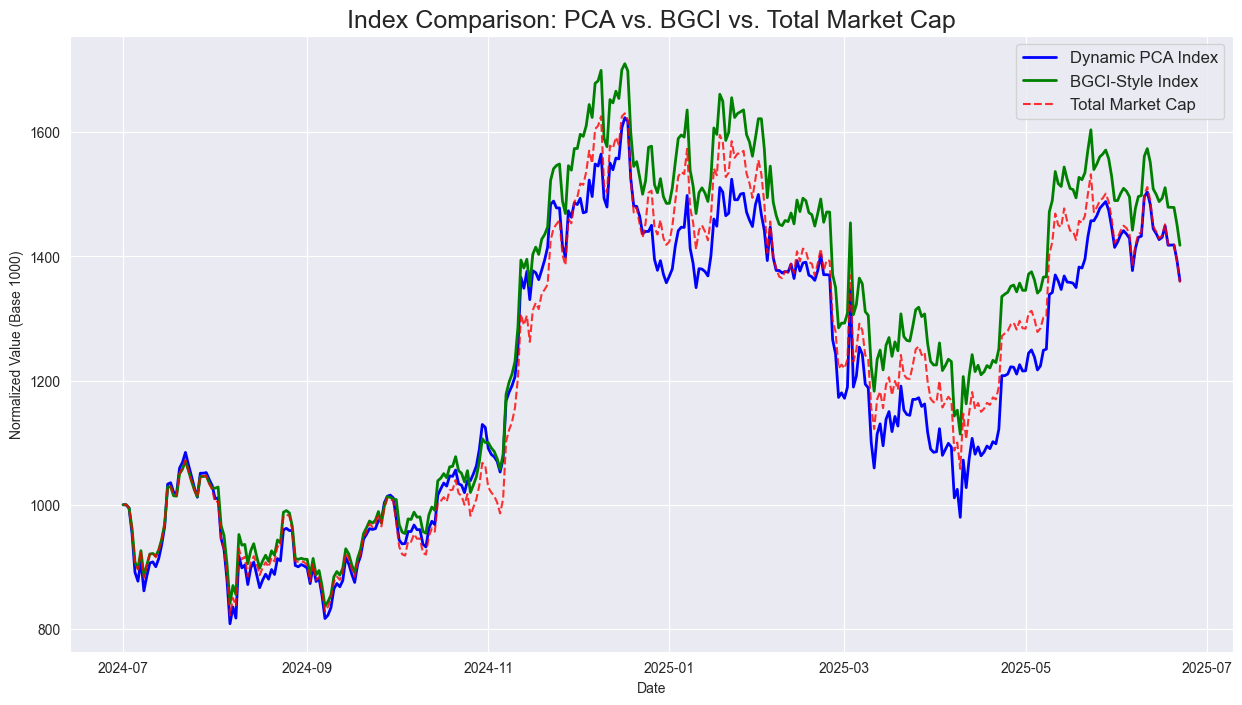

In [4]:
# Cell: Final Comparison Plot (PCA vs. BGCI vs. Market Cap)

print("--- Generating Final Index Comparison Plot ---")

# --- 1. Load all three necessary data series ---
try:
    # Load your original dynamic PCA index
    pca_index = pd.read_csv(config.PROCESSED_DATA_DIR / 'dynamic_pca_index_new.csv', 
                            index_col='Date', parse_dates=True)['Value']
    
    # Load your new BGCI-style index
    bgci_index = pd.read_csv(config.PROCESSED_DATA_DIR / 'bgci_style_index.csv', 
                             index_col='Date', parse_dates=True)['BGCI_Style_Index']
    
    # Load the full market cap data to calculate the total
    market_caps = pd.read_csv(config.MARKET_CAP_FILE_PATH, 
                              index_col='Date', parse_dates=True)
    
    print("All data files loaded successfully.")
    
except FileNotFoundError as e:
    print(f"ERROR: Missing data file. Please ensure all index calculation scripts have been run. Missing: {e.filename}")
    # Stop execution if a file is missing
    assert False, "Required data file not found."

# --- 2. Prepare Data for Plotting ---

# Calculate the total market capitalization
total_market_cap = market_caps.sum(axis=1)

# Combine all three series into a single DataFrame and align them to common dates
comparison_df = pd.DataFrame({
    'PCA_Index': pca_index,
    'BGCI_Style_Index': bgci_index,
    'Total_Market_Cap': total_market_cap
}).dropna() # Drop any dates where one of the series might not have data

# --- 3. Normalize Data to a Common Starting Point (Base 1000) ---
# This is essential for a fair visual comparison.
normalized_df = 1000 * (comparison_df / comparison_df.iloc[0])

print("Data has been normalized to a base of 1000 for comparison.")

# --- 4. Create the Plot ---
plt.figure(figsize=(15, 8))

plt.plot(normalized_df.index, normalized_df['PCA_Index'], label='Dynamic PCA Index', color='blue', linewidth=2)
plt.plot(normalized_df.index, normalized_df['BGCI_Style_Index'], label='BGCI-Style Index', color='green', linewidth=2)
plt.plot(normalized_df.index, normalized_df['Total_Market_Cap'], label='Total Market Cap', color='red', linestyle='--', alpha=0.8)

plt.title('Index Comparison: PCA vs. BGCI vs. Total Market Cap', fontsize=18)
plt.ylabel('Normalized Value (Base 1000)')
plt.xlabel('Date')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()